## XGBoost for Scorecarding demo 

### Code by: Stephen Denton, Scotiabank

In [ ]:
# !pip install dask

In [84]:
## Import WOESC library (which will import a number of other libraries: pandas, numpy, dask...)
from data_utils import *

import sys
from scipy.stats import ks_2samp

from sklearn import metrics
from sklearn import model_selection

import xgboost as xgb

pd.set_option('display.max_columns', None)

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("scipy version:", sys.modules['scipy'].__version__)
print("matplotlib version:", sys.modules['matplotlib'].__version__)
print("scikit-learn version:", sys.modules['sklearn'].__version__)
print("XGBoost version:", xgb.__version__)

numpy version: 1.24.2
pandas version: 1.5.3
scipy version: 1.10.1
matplotlib version: 3.7.1
scikit-learn version: 1.2.2
XGBoost version: 1.7.5


## Import some data

Dataset should include a binary target variable that indicates if the behavior we are interested in predicting occurred *after* the rest of the data was collected.

The below data set has a **loan_default** variable that will be the target for the model.

In [85]:
## Import training data from kaggle: https://www.kaggle.com/sneharshinde/ltfs-av-data
dataset = pd.read_csv('train.csv')

## Get some basic information about the dataset
print("Shape of the dataset (rows, columns):", dataset.shape, "\n")
dataset.info()

Shape of the dataset (rows, columns): (233154, 41) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate              

In [86]:
## Show the first n records in the dataset
dataset.head(8)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,19-09-18,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,23-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,16-09-18,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0


In [87]:
## Specify special columns in the dataset that are identification or target variables
## You can have multiple id_vars, hence it is required to be a list 
id_vars = ['UniqueID']
targ_var = 'loan_default'

# Perform some (optional) feature engineering and dataset clean-up
dataset = preprocess_vehicle_data(dataset, id_vars, targ_var)
dataset.sample(10, random_state=0).sort_index()

,UniqueID,loan_default,disbursed_amount,asset_cost,ltv,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERF_CNS_SC_DESC,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_LAST_6_MTHS,DELI_ACCTS_LAST_6_MTHS,NO_OF_INQUIRIES,AgeInMonths,DaysSinceDisbursement,AcctAgeInMonths,CreditHistLenInMonths
36826,454954,0,50903,69149,75.20,86,Salaried,4,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,520.0,132.0,0,0
53030,471430,0,57822,69420,85.00,86,Salaried,8,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,643.0,125.0,0,0
89937,508984,0,62447,81500,78.53,86,Salaried,4,1,1,0,0,0,597.0,I-Medium Risk,1.0,1.0,0.0,0.0,190000.0,190000.0,0,0,0,0,0,0,0.0,0,0,0,0,389.0,108.0,28,28
96740,515897,0,49803,66089,77.17,86,Self employed,6,1,0,0,0,0,NaN,Not Scored: No Updates available in last 36 mo...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,479.0,105.0,34,34
133959,553618,1,61613,78000,80.00,120,Self employed,4,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,537.0,93.0,0,0
148894,568733,0,56259,67500,84.44,86,Self employed,9,0,0,1,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,468.0,82.0,0,0
156462,576398,0,50303,65240,79.71,51,Self employed,1,1,0,0,0,0,818.0,A-Very Low Risk,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,900.0,0,0,0,0,432.0,80.0,6,6
164491,584480,0,48682,67295,74.45,51,Self employed,1,1,0,0,0,0,762.0,B-Very Low Risk,1.0,1.0,0.0,0.0,40000.0,40000.0,0,0,0,0,0,0,2639.0,0,0,0,1,572.0,76.0,22,22
202730,623317,0,49053,61310,82.37,45,Self employed,4,0,0,1,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,480.0,67.0,0,0
210916,631654,0,43794,70211,63.24,49,Self employed,3,1,0,0,0,0,551.0,J-High Risk,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,1,0,372.0,66.0,8,8


In [88]:
## Get summary of data target using convenience function 'describe_data_g_targ'
## Note: The 'Null' model predicts the base rate for all training data - in ML called a Dummy Classifier Baseline
datdict = describe_data_g_targ(dataset, targ_var) # , logbase=2);

Number of records (num): 233154
Target count (n_targ): 50611
Target rate (base_rate): 0.2170711203753742
Target odds (base_odds): 0.2772552220572687
Target log odds (base_log_odds): -1.2828168177360064
Dummy model negative log-likelihood (NLL_null): 121980.55416139046
Dummy model LogLoss (LogLoss_null): 0.5231759015989023



In [89]:
non_p_vars = id_vars + [targ_var]
p_vars = dataset.columns.drop(non_p_vars).tolist()
num_p_vars = sorted(dataset[p_vars]._get_numeric_data().columns)
cat_p_vars = sorted(set(dataset[p_vars].columns) - set(num_p_vars))
len(p_vars), len(num_p_vars), len(cat_p_vars)

(34, 25, 9)

In [90]:
## One-hot encode categorical variables
x_dat = dataset.loc[:, non_p_vars + num_p_vars]
x_dat_c = dataset.loc[:, cat_p_vars]
dxx = pd.get_dummies(x_dat_c, prefix_sep='__')
x_dat.shape, x_dat_c.shape, dxx.shape

((233154, 27), (233154, 9), (233154, 65))

In [91]:
## Regenerate dataset from components 
print(dataset.shape)
dataset = pd.concat([x_dat, dxx], axis=1, sort=False)
print(dataset.shape)

## Regenerate p_vars to include one-hot encoded variables.
p_vars = list(dataset.columns.drop(non_p_vars))

(233154, 36)
(233154, 92)


In [92]:
## Split data into training and validation sets
trndat, valdat = model_selection.train_test_split(dataset, test_size=0.5, random_state=0, stratify=dataset[[targ_var]])
print(trndat[targ_var].value_counts())
print(valdat[targ_var].value_counts())

0    91271
1    25306
Name: loan_default, dtype: int64
0    91272
1    25305
Name: loan_default, dtype: int64


In [93]:
trndat.head()

,UniqueID,loan_default,AcctAgeInMonths,AgeInMonths,CreditHistLenInMonths,DELI_ACCTS_LAST_6_MTHS,DaysSinceDisbursement,NEW_ACCTS_LAST_6_MTHS,NO_OF_INQUIRIES,PERFORM_CNS_SCORE,PRIMARY_INSTAL_AMT,PRI_ACTIVE_ACCTS,PRI_CURRENT_BALANCE,PRI_DISBURSED_AMOUNT,PRI_NO_OF_ACCTS,PRI_OVERDUE_ACCTS,PRI_SANCTIONED_AMOUNT,SEC_ACTIVE_ACCTS,SEC_CURRENT_BALANCE,SEC_DISBURSED_AMOUNT,SEC_INSTAL_AMT,SEC_NO_OF_ACCTS,SEC_OVERDUE_ACCTS,SEC_SANCTIONED_AMOUNT,asset_cost,disbursed_amount,ltv,Aadhar_flag__0,Aadhar_flag__1,Driving_flag__0,Driving_flag__1,Employment_Type__Salaried,Employment_Type__Self employed,PAN_flag__0,PAN_flag__1,PERF_CNS_SC_DESC__,PERF_CNS_SC_DESC__A-Very Low Risk,PERF_CNS_SC_DESC__B-Very Low Risk,PERF_CNS_SC_DESC__C-Very Low Risk,PERF_CNS_SC_DESC__D-Very Low Risk,PERF_CNS_SC_DESC__E-Low Risk,PERF_CNS_SC_DESC__F-Low Risk,PERF_CNS_SC_DESC__G-Low Risk,PERF_CNS_SC_DESC__H-Medium Risk,PERF_CNS_SC_DESC__I-Medium Risk,PERF_CNS_SC_DESC__J-High Risk,PERF_CNS_SC_DESC__K-High Risk,PERF_CNS_SC_DESC__L-Very High Risk,PERF_CNS_SC_DESC__M-Very High Risk,PERF_CNS_SC_DESC__Not Scored: More than 50 active Accounts found,PERF_CNS_SC_DESC__Not Scored: No Activity seen on the customer (Inactive),PERF_CNS_SC_DESC__Not Scored: No Updates available in last 36 months,PERF_CNS_SC_DESC__Not Scored: Not Enough Info available on the customer,PERF_CNS_SC_DESC__Not Scored: Only a Guarantor,PERF_CNS_SC_DESC__Not Scored: Sufficient History Not Available,Passport_flag__0,Passport_flag__1,State_ID__1,State_ID__10,State_ID__11,State_ID__12,State_ID__13,State_ID__14,State_ID__15,State_ID__16,State_ID__17,State_ID__18,State_ID__19,State_ID__2,State_ID__20,State_ID__21,State_ID__22,State_ID__3,State_ID__4,State_ID__5,State_ID__6,State_ID__7,State_ID__8,State_ID__9,VoterID_flag__0,VoterID_flag__1,manufacturer_id__120,manufacturer_id__145,manufacturer_id__152,manufacturer_id__153,manufacturer_id__156,manufacturer_id__45,manufacturer_id__48,manufacturer_id__49,manufacturer_id__51,manufacturer_id__67,manufacturer_id__86
93939,513034,1,0,514.0,0,0,106.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,70218,61613,89.72,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
206699,627332,0,0,615.0,0,0,67.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,61421,36921,62.52,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
183667,603958,0,11,373.0,11,0,70.0,0,0,737.0,0.0,1.0,162146.0,215000.0,1.0,0.0,215000.0,0,0,0,0,0,0,0,63580,49099,78.64,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
42215,460437,0,0,552.0,0,0,130.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,101500,74123,73.89,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
135396,555074,0,0,343.0,0,0,90.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,80364,59013,74.66,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [94]:
## Get summary of target for training dataset
trndict = describe_data_g_targ(trndat, targ_var)

Number of records (num): 116577
Target count (n_targ): 25306
Target rate (base_rate): 0.217075409386071
Target odds (base_odds): 0.27726221910574006
Target log odds (base_log_odds): -1.2827915812043762
Dummy model negative log-likelihood (NLL_null): 60990.918482794936
Dummy model LogLoss (LogLoss_null): 0.5231814035598354



In [95]:
## Get the target rate for the training dataset
#base_rate = trndict['base_rate'].round(6)
base_rate = round(trndict['base_rate'], 6)
base_rate

0.217075

In [96]:
## Extract target column as a series
y_trn = trndat.loc[:,targ_var].astype(int)
y_val = valdat.loc[:,targ_var].astype(int)

In [97]:
## Set feature interaction constraints such that no between variable interactions are allowed
x_constraints = []
interaction_constraints = []

dat_cols = pd.Index(p_vars)
ind_vars = sorted(set([item[0] for item in dat_cols.str.split('__')]))

for iv in ind_vars:
    if np.any(dat_cols.isin([iv])):
        f_var = [dat_cols.get_loc(iv)]
        f_var_name = [dat_cols[f_var[0]]]
    else:
        f_var = []
        f_var_name = []
    
    x_constraints.append(f_var_name + list(dat_cols[np.where(dat_cols.str.startswith(iv+'__'))[0]]) )
    interaction_constraints.append(f_var + list(np.where(dat_cols.str.startswith(iv+'__'))[0]) )
    
x_constraints[:5]

[['Aadhar_flag__0', 'Aadhar_flag__1'],
 ['AcctAgeInMonths'],
 ['AgeInMonths'],
 ['CreditHistLenInMonths'],
 ['DELI_ACCTS_LAST_6_MTHS']]

In [98]:
## Specify which variables are required to have a monotonic relationship with the outcome variable
monotonic_vars = ['CreditHistLenInMonths', 'PERFORM_CNS_SCORE', 'AgeInMonths', 'ltv']
monotone_constraints = pd.Series(0, index=p_vars)
for mono_var in monotonic_vars:
    monotone_constraints[mono_var] = 1

monotone_constraints_str = "("+ ",".join([str(i) for i in monotone_constraints.values]) +")"
print(monotone_constraints_str)

(0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)


In [99]:
val_metrics = ['auc', 'logloss']

bst_params = {
    'base_score': base_rate 
    , 'gamma': 1               ## def: 0
    , 'learning_rate': 0.5     ## def: 0.1
    , 'max_depth': 3
    , 'min_child_weight': 100  ## def: 1
    , 'n_estimators': 50
    , 'nthread': 24 
    , 'objective': 'binary:logistic'
#     , 'random_state': 0
    , 'reg_alpha': 0
    , 'reg_lambda': 0          ## def: 1
#     , 'scale_pos_weight': 1
#     , 'subsample': 1
#     , 'verbosity': 1
    , 'interaction_constraints': str(interaction_constraints)
    , 'monotone_constraints': monotone_constraints_str
    , 'eval_metric': val_metrics
    , 'tree_method': 'hist'    ## def: 'auto'
}

In [100]:
# Initialize and run XGBoostClassifier
xgbmodel = xgb.XGBClassifier(**bst_params, use_label_encoder=False)
xgbmodel.fit(trndat[p_vars], y_trn, eval_set=[(valdat[p_vars], y_val)], early_stopping_rounds=20)
bstr = xgbmodel.get_booster()

print((bstr.best_score, bstr.best_iteration, bstr.best_ntree_limit))

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.56925	validation_0-logloss:0.51923
[1]	validation_0-auc:0.58978	validation_0-logloss:0.51679
[2]	validation_0-auc:0.60506	validation_0-logloss:0.51470
[3]	validation_0-auc:0.60919	validation_0-logloss:0.51281
[4]	validation_0-auc:0.61641	validation_0-logloss:0.51156
[5]	validation_0-auc:0.62208	validation_0-logloss:0.51039
[6]	validation_0-auc:0.62056	validation_0-logloss:0.50960
[7]	validation_0-auc:0.62677	validation_0-logloss:0.50859
[8]	validation_0-auc:0.62991	validation_0-logloss:0.50793
[9]	validation_0-auc:0.63078	validation_0-logloss:0.50726
[10]	validation_0-auc:0.63331	validation_0-logloss:0.50672
[11]	validation_0-auc:0.63533	validation_0-logloss:0.50620
[12]	validation_0-auc:0.63702	validation_0-logloss:0.50581
[13]	validation_0-auc:0.63562	validation_0-logloss:0.50548
[14]	validation_0-auc:0.63702	validation_0-logloss:0.50490
[15]	validation_0-auc:0.63774	validation_0-logloss:0.50454
[16]	validation_0-auc:0.63935	validation_0-logloss:0.50400
[17]	va

In [101]:
print("***** VALIDATION DATA STATISTICS *****")
valYpreds = xgbmodel.predict_proba(valdat[p_vars])[:,1]
LL = -(y_val * np.log(valYpreds) + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)
print( ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0]) )
print( "AUC =", metrics.roc_auc_score(y_val, valYpreds), ', LL =', LL, '(iter {})'.format(bstr.best_iteration) )

***** VALIDATION DATA STATISTICS *****
KstestResult(statistic=0.21373240938592825, pvalue=0.0, statistic_location=0.22612366, statistic_sign=-1)
AUC = 0.647807789321232 , LL = 0.5000333459670845 (iter 48)


In [103]:
print("***** TRAINING DATA STATISTICS *****")
trnYpreds = xgbmodel.predict_proba(trndat[p_vars])[:,1]
LL = -(y_trn * np.log(trnYpreds) + (1-y_trn) * np.log(1-trnYpreds)).sum() / len(y_trn)
print("LogLoss =", LL)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_trn, trnYpreds) 
print("KS =",  max(true_positive_rate - false_positive_rate))
print("AUC =", metrics.auc(false_positive_rate, true_positive_rate))

***** TRAINING DATA STATISTICS *****
LogLoss = 0.4988597787994664
KS = 0.2203964847051137
AUC = 0.6513310206409546


In [104]:
print("Total cuts:", sum(bstr.get_fscore().values()))
print("Number of variables in booster model:", len(bstr.get_fscore().keys()))
print("Number of independent variables in booster model:", 
      pd.Series(list(bstr.get_fscore().keys())).str.split('__').map(lambda x: x[0]).nunique())

Total cuts: 188.0
Number of variables in booster model: 41
Number of independent variables in booster model: 21


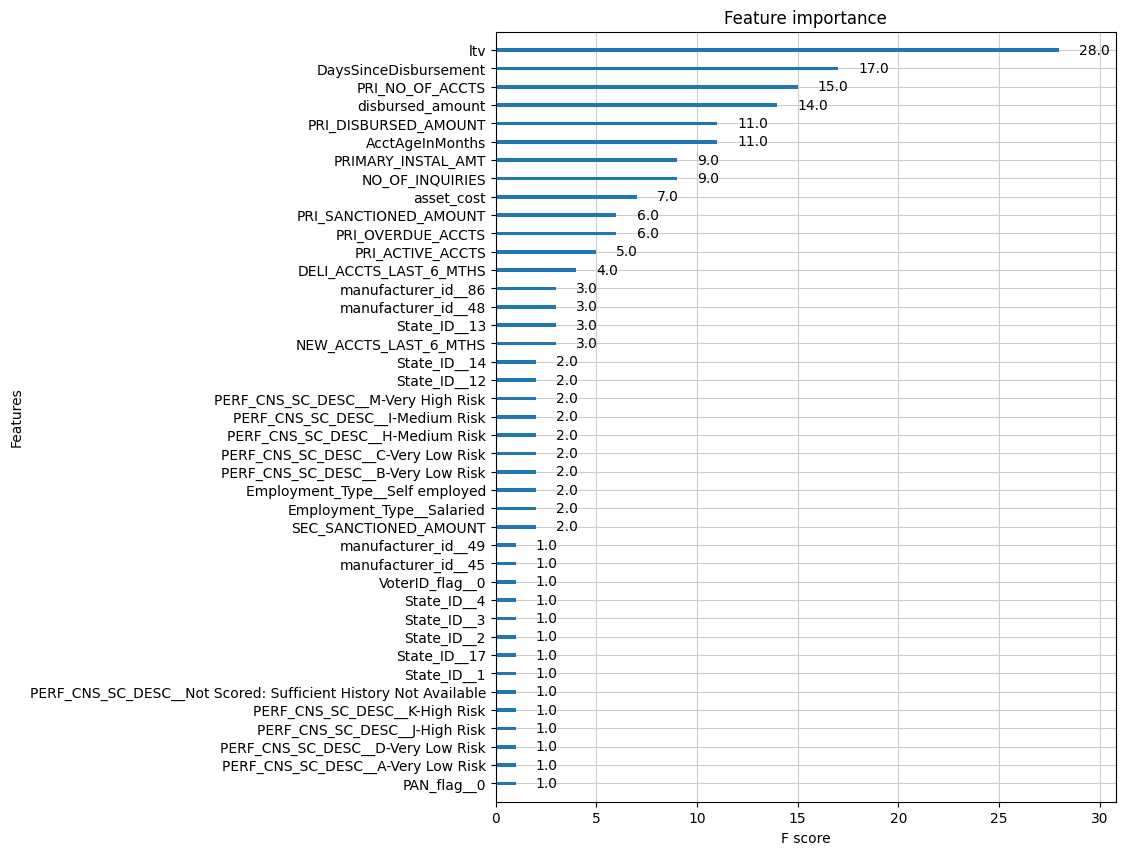

In [105]:
_, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(xgbmodel, ax=ax)
plt.show()

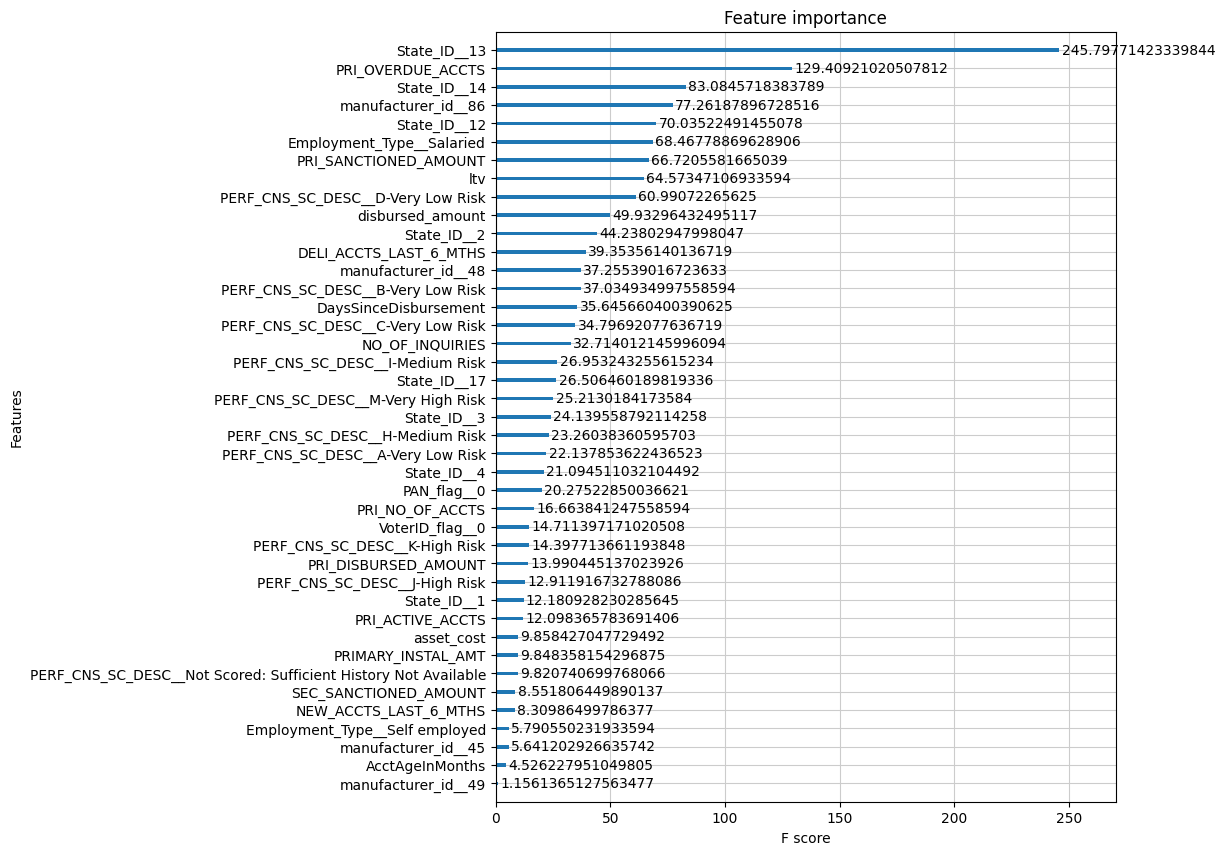

In [106]:
_, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(xgbmodel, importance_type='gain', ax=ax)
plt.show()

In [107]:
## Create Scorecard
mdf = bstr.trees_to_dataframe()
mdf_parents = mdf[mdf.Feature!='Leaf'].drop(columns=['Tree','Gain','Cover'])
mdf_leafs = mdf[mdf.Feature=='Leaf'].drop(columns=['Feature','Split','Yes','No','Missing','Cover', 'Category'])
mdf_leafs.rename(columns={'ID': 'ID0', 'Node': 'Node0'}, inplace=True)

tree_traceback = pd.DataFrame() # empty
itr = 0 
itrs = str(itr)
while mdf_leafs.shape[0] > 0:
    NoSprout = pd.merge(mdf_leafs, mdf_parents, how='inner', left_on='ID'+itrs, right_on='No')
    YesSprout = pd.merge(mdf_leafs, mdf_parents, how='inner', left_on='ID'+itrs, right_on='Yes')
    MissingSprout = pd.merge(mdf_leafs, mdf_parents, how='inner', left_on='ID'+itrs, right_on='Missing')
    MissingSprout.Split = np.nan
    
    itr += 1
    itrs = str(itr)    
    NoSprout.insert(NoSprout.shape[1]-4, 'Sign'+itrs, '>=')
    YesSprout.insert(YesSprout.shape[1]-4, 'Sign'+itrs, '<')
    MissingSprout.insert(MissingSprout.shape[1]-4, 'Sign'+itrs, '.')
    mdf_leafs = pd.concat([NoSprout, YesSprout, MissingSprout]) 
    mdf_leafs.rename(columns={'ID':'ID'+itrs, 'Split':'Split'+itrs, 'Feature':'Feature'+itrs, 'Node':'Node'+itrs, 
                             'Yes':'Yes'+itrs, 'No':'No'+itrs, 'Missing':'Missing'+itrs}, inplace=True)
    # appending the traceback
    tree_traceback = tree_traceback.append(mdf_leafs.loc[mdf_leafs['Node'+itrs]==0,:], sort=False)
    mdf_leafs = mdf_leafs[mdf_leafs['Node'+itrs]!=0]

ttb_missing = tree_traceback.copy()
ttb_non_missing = tree_traceback.copy()

for i in range(1,itr+1):
    ttb_missing = ttb_missing[(ttb_missing['Sign'+str(i)] == '.') | ttb_missing['Sign'+str(i)].isna()]
    ttb_non_missing = ttb_non_missing[ttb_non_missing['Sign'+str(i)] != '.']

ttb = ttb_non_missing.copy()
ttb.sort_values(['Tree', 'Split1', 'Sign1'], inplace=True, na_position='first')
ttb.reset_index(drop=True, inplace=True)

sc_df = ttb.iloc[:,:4].rename(columns={'ID0':'ID', 'Node0':'Node', 'Gain':'XAddEvidence'}).copy()
sc_df['Feature'] = ttb.Feature1.values
sc_df['Sign'] = ttb.Sign1.values
sc_df['Split'] = ttb.Split1.values

for i in range(1,itr): 
    replace_in_sc = ( ( sc_df['Sign']=='>=').values 
                        & (ttb['Split'+str(i)] < ttb['Split'+str(i+1)]).values 
                        & (ttb['Feature'+str(i)] == ttb['Feature'+str(i+1)]).values ) 
    sc_df.loc[replace_in_sc,'Sign'] = ttb['Sign'+str(i+1)][replace_in_sc].values
    sc_df.loc[replace_in_sc,'Split'] = ttb['Split'+str(i+1)][replace_in_sc].values

sc_df['Inc_Missing'] = sc_df.ID.isin(ttb_missing.ID0).astype(int)    

## Move 'XAddEvidence' to the far right of sc_df
cols = sc_df.columns.to_list()
cols.pop(cols.index('XAddEvidence')) 
sc_df = sc_df[cols+['XAddEvidence']] 

## Reformat categorical variables
OTHER_CAT_IND = "OTHER"  ## The label for the all other items in categorical variable
feature_decomp = sc_df.Feature.str.split('__', n=1, expand=True)
cat_rows = ~feature_decomp[1].isna()
other_cat_rows = (cat_rows & (sc_df['Sign'] == '<')).values
feat_categories = feature_decomp.iloc[:,1].copy()
feat_categories.loc[other_cat_rows] = OTHER_CAT_IND
sc_df.loc[cat_rows, 'Split'] = feat_categories[cat_rows].values
sc_df.loc[cat_rows, 'Feature'] = feature_decomp[0][cat_rows].values
sc_df.loc[cat_rows, 'Sign'] = "="
sc_df.loc[cat_rows, 'Inc_Missing'] = 0

sc_df.sort_values(['Tree', 'Sign', 'Split'], inplace=True, na_position='last')
sc_df.set_index(['Tree'], inplace=True)

scorecard = sc_df.drop(columns=['Node', 'ID'])

pd.set_option('display.max_rows', scorecard.shape[0]+1)
scorecard

/tmp/ipykernel_1454/1730273836.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tree_traceback = tree_traceback.append(mdf_leafs.loc[mdf_leafs['Node'+itrs]==0,:], sort=False)
/tmp/ipykernel_1454/1730273836.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tree_traceback = tree_traceback.append(mdf_leafs.loc[mdf_leafs['Node'+itrs]==0,:], sort=False)
/tmp/ipykernel_1454/1730273836.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tree_traceback = tree_traceback.append(mdf_leafs.loc[mdf_leafs['Node'+itrs]==0,:], sort=False)


,Feature,Sign,Split,Inc_Missing,XAddEvidence
Tree,,,,,
0,ltv,<,57.68,0,-0.247453
0,ltv,<,66.940002,0,-0.165440
0,ltv,<,68.830002,0,-0.117209
0,ltv,<,72.93,0,-0.061664
0,ltv,<,78.550003,0,0.004815
0,ltv,<,79.279999,0,0.053643
0,ltv,<,83.32,0,0.084554
0,ltv,>=,83.32,1,0.143894
1,State_ID,=,12,0,0.240978


,Feature,Sign,Split,Inc_Missing,XAddEvidence
Tree,,,,,
0,ltv,<,57.68,0,-0.247453
0,ltv,<,66.940002,0,-0.165440
0,ltv,<,68.830002,0,-0.117209
0,ltv,<,72.93,0,-0.061664
0,ltv,<,78.550003,0,0.004815
0,ltv,<,79.279999,0,0.053643
0,ltv,<,83.32,0,0.084554
0,ltv,>=,83.32,1,0.143894


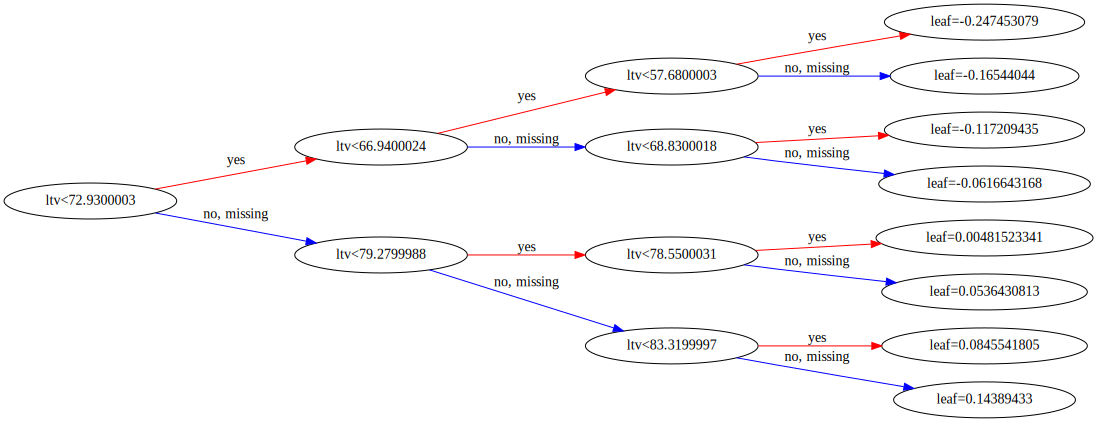

In [108]:
tree_i=0
display(scorecard.loc[[tree_i]])
xgb.to_graphviz(xgbmodel, num_trees=tree_i, rankdir='LR')

,Feature,Sign,Split,Inc_Missing,XAddEvidence
Tree,,,,,
17,PERF_CNS_SC_DESC,=,B-Very Low Risk,0,-0.146294
17,PERF_CNS_SC_DESC,=,C-Very Low Risk,0,-0.090636
17,PERF_CNS_SC_DESC,=,D-Very Low Risk,0,-0.127214
17,PERF_CNS_SC_DESC,=,OTHER,0,0.018369


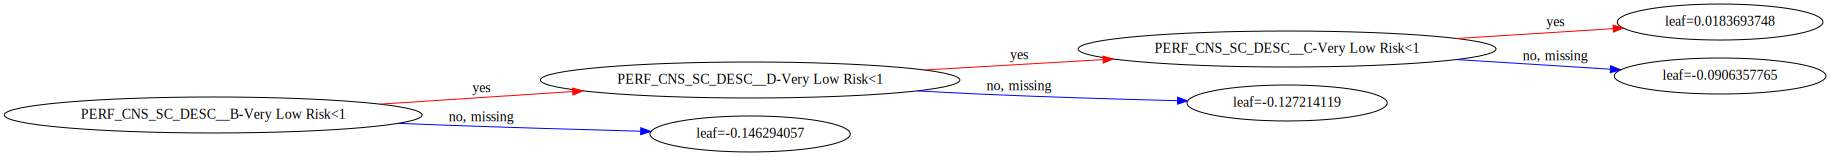

In [109]:
tree_i = 17
display(scorecard.loc[[tree_i]])
xgb.to_graphviz(xgbmodel, num_trees=tree_i, rankdir='LR')